```{currentmodule} tskit
```

(sec_tskit_no_mutations)=

# Do you really need mutations?

In tree sequences, the genetic genealogy exists independently of the mutations that
generate genetic variation, and often we are primarily interested in genetic variation
because of what it can tell us about those genealogies. This tutorial aims to illustrate
when we can leave mutations and genetic variation aside and study the genealogies directly.

In simulations we know the true genealogies, and so it can be very helpful to work
with these directly. 
In real data, we might infer the trees and then work with the resulting genealogies.
(Of course, mutations add additional noise, and would be necessary
to produce data directly comparable to sequencing data.)
If you're wondering whether you need to add mutations at all,
it's worth considering the following points:

1. Neutral mutations and sites can always be added to a genealogy later
2. Simulating sites and mutations increases memory requirements and tree
sequence file size somewhat, as well as adding to CPU time (although usually this is
inconsequential)
3. Quantities of interest can often be inferred equally well (or better!) on tree sequences
that have no sites or mutations.

To illustrate the first two points, we can use the [msprime](https://tskit.dev/msprime)
{func}`~msprime.sim_mutations` function to add neutral sites and mutations onto an
simulated mutationless tree sequence of 20 diploid individuals:

In [1]:
import msprime
L = 1_000_000  # simulate 1 megabase length (could increase for a larger example)
rho = mu = 1e-8  # Human-like recombination and mutation parameters
n_subpops = 2
subpop_size = 1e4
migration_rate = 1e-4
# Create a mutationless diploid tree sequence of n_subpops demes
ts_no_mut = msprime.sim_ancestry(
    samples={f"pop_{i}": 10 for i in range(n_subpops)},  # 10 samples from each subpop
    demography=msprime.Demography.island_model([subpop_size] * n_subpops, migration_rate),
    ploidy=2,
    recombination_rate=rho,
    sequence_length=L,
    random_seed=123,
)

# Optionally, add neutral mutations later, after simulating. This takes some CPU time
# (although it is usually fast compared to simulating the original tree sequence)
ts_mutated = msprime.sim_mutations(ts_no_mut, rate=mu, random_seed=456)
print(
    "Adding mutations has increased the tree sequence file size by "
    f"{ts_mutated.nbytes / ts_no_mut.nbytes * 100:.0f}%",
)

Adding mutations has increased the tree sequence file size by 151%


:::{note}
Above we have overlaid sites and mutations onto an existing tree sequence by simulation.
It is also possible to overlay mutations in such a way as to generate a known pattern of
genetic variation, using {meth}`tskit.Tree.map_mutations`.
:::


Although including mutations has increased the file size a fair bit in this example,
unless you are running simulations with vast numbers of mutations, tree sequences are
usually compact enough that the cost of including them shouldn't be prohibitive.
Nevertheless, it may not be obvious that it is perfectly possible, indeed sometimes
preferable, to perform genetic analyses on tree sequences that do not contain mutations
and variable sites. This is the focus of the remainder of this tutorial.


## Analysis in the absence of genetic variation

### Patterns of relationship

Some genetic analyses are primarily focussed on patterns or degrees of relationship
between genomes. In this case, the genealogy tells you all you need to know.
This includes:

* analyses of local ancestry, global ancestry and identity-by-descent
* identification of most recent common ancestors and their descendants (including e.g.
genealogical nearest neighbour analysis)

Although these methods are primarily described elsewhere, the code below illustrates
how a tree sequence without mutations can be used to find the average time to the
most recent common ancestor (tMRCA) of two sample genomes. The genomes have been
pcked at random from the two different populations, and the times averaged over
the entire 1Mb genome.

In [2]:
import numpy as np
np.random.seed(10)
sample_a = np.random.choice(ts_no_mut.samples(population=0), size=1)[0]
sample_b = np.random.choice(ts_no_mut.samples(population=1), size=1)[0]
av_tMRCA = 0
for tree in ts_no_mut.trees():
    # weight the tMRCA by the span of genome covered
    av_tMRCA += tree.tmrca(sample_a, sample_b) * tree.span/ts_no_mut.sequence_length
print(f"Average tMRCA between sample {sample_a} (pop_0) and",
      f"{sample_b} (pop_1) is {av_tMRCA:.2f} {ts_no_mut.time_units}")

Average tMRCA between sample 9 (pop_0) and 24 (pop_1) is 42396.75 generations


### Genetic statistics and branch-length equivalents

Although many genetic analyses are based on patterns of genetic variation, for many
purposes the genetic variation can be thought of as a measure of the relative length of
branches on the local trees in a tree sequence. So while mutations are necessary to
generate realistically variable genetic sequences, some statistical analyses do not
necessarily require them to be present in a tree sequence (see
[this paper](https://doi.org/10.1534/genetics.120.303253) which explains the duality
between statistics based on genetic variation and their branch length equivalents).
Such statistics include all those based on the allele frequency spectrum, such as genetic
diversity and Tajima's D, and those based on genetic divergence between populations
such as Fst and Patterson's f statistics.

A simple example of a statistic that is normally calculated by looking at variable sites
is the genetic divergence. This is usually defined as the
proportion of the genome that differs between two sample genomes. In a tree sequence with
mutations, it can be calculated using the {meth}`~TreeSequence.divergence` method:

In [3]:
# By default, estimating average "genetic divergence" requires mutations to be present
print(
    f"Genetic divergence between samples {sample_a} and {sample_b} is",
    f"{ts_mutated.divergence([[sample_a], [sample_b]]):.6f}"
)

Genetic divergence between samples 9 and 24 is 0.000840


If mutation rates are low (i.e. when the "infinite sites" model of mutation is
a good approximation), each genetic difference between sequences corresponds to a
mutation on the lineage connecting the two samples. Since the number of mutations is
expected to be proportional to the length of the lineage, we can use the
lineage length directly to measure divergence (in this case adding the branch length
from the first sample to the MRCA and the branch from the MRCA to the second sample).
The {ref}`general statistics framework<tskit:sec_stats_mode>`, allows you to switch to
these "branch length" measures by using the `mode="branch"` parameter:

In [4]:
# By default, statistics are calculated base on variable sites (mode="site"), but
# we can switch to the branch-length equivalent using mode = "branch"
sample_sets = [sample_a], [sample_b]
ab_dist = ts_no_mut.divergence(sample_sets, mode="branch")
print(
    f"Av. genealogical distance between samples {sample_a} and {sample_b} is",
    f"{ab_dist:.1f} {ts_no_mut.time_units}"
)
print("With both samples at time 0, this is twice the previously calculated av tMRCA:")
print(f" av_tMRCA was {av_tMRCA:.1f} (2 * {av_tMRCA:.1f} = {2 * av_tMRCA:.1f})")

# To compare it to the standard genetic divergence, simply multiply by the mutation rate
print(
    f"Estimated genetic divergence from the genealogy is",
    f"{ts_no_mut.divergence(sample_sets, mode='branch') * mu:.6f}"
)

Av. genealogical distance between samples 9 and 24 is 84793.5 generations
With both samples at time 0, this is twice the previously calculated av tMRCA:
 av_tMRCA was 42396.8 (2 * 42396.8 = 84793.5)
Estimated genetic divergence from the genealogy is 0.000848


#### Genealogy-based measures are less noisy

Analyses based on observed genetic variation have a random component due to the
stochastic nature of the mutational process. This "random mutational noise" is missing
from analyses that use the genealogy directly: something that is particularly evident
when the analysis is dependent on a small number of mutations.  Here's an example
which contrasts conventional and branch length versions of the well-known $F_{st}$
statistic, across the two populations we previously simulated.

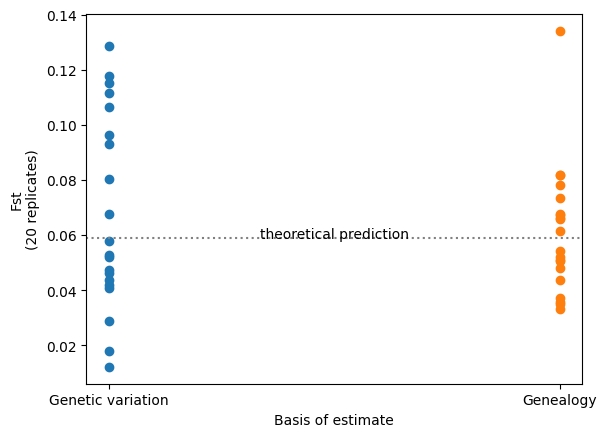

In [5]:
import matplotlib_inline
import matplotlib.pyplot as plt

n_reps = 20
ts_reps = list(msprime.sim_ancestry(
    samples={f"pop_{i}": 10 for i in range(n_subpops)},
    demography=msprime.Demography.island_model([subpop_size] * n_subpops, migration_rate),
    ploidy=2,
    recombination_rate=rho,
    sequence_length=L,
    random_seed=123,
    num_replicates=n_reps,
))

ts_mutated_reps = [
    # Decrease the mutation rate to exaggerate effect of random mutational noise
    msprime.sim_mutations(ts, rate=mu/100, random_seed=i+4) 
    for i, ts in enumerate(ts_reps)
]

# Return sample sets as all samples from each population (uses all pairwise comparisons)
def sample_sets(ts):
    return [ts.samples(population=p.id) for p in ts.populations()]

Fst_genealogy = np.array([ts.Fst(sample_sets(ts), mode="branch") for ts in ts_reps])
Fst_genetic_var = np.array([ts.Fst(sample_sets(ts)) for ts in ts_mutated_reps])

# For the theoretical expectation see e.g. Crow and Aoki (1984) PNAS 81: 6073, eqn 7
Fst_theory = 1/(4*subpop_size*migration_rate*(n_subpops/(n_subpops-1))**2 + 1)

plt.scatter(["Genetic variation"] * 20, Fst_genetic_var)
plt.scatter(["Genealogy"] * 20, Fst_genealogy)
plt.xlabel("Basis of estimate")
plt.ylabel("Fst\n(20 replicates)")

plt.axhline(y=Fst_theory, ls=":", c="grey")
plt.text(0.5, Fst_theory, 'theoretical prediction', ha='center')
plt.show()

::::{margin}
:::{note}
In real data there is additional noise introduced by
inference of the underlying tree sequence which is not accounted for in these examples
:::
::::

Therefore, if your ultimate goal is to compare or estimate genetic statistics of this
sort (rather than to examine the genetic sequence itself), then using the
genealogy-based approach should give you more statistical power.

As with genetic diversity, there also exist a "branch length" version of the allele
frequency spectrum (the AFS), which measures the length of branches subtending 1 sample,
2 samples, 3 samples, etc. This is a slightly less noisy version of the AFS based on
actual allele frequencies, and it too can be calculated on a tree sequence with no
mutations:

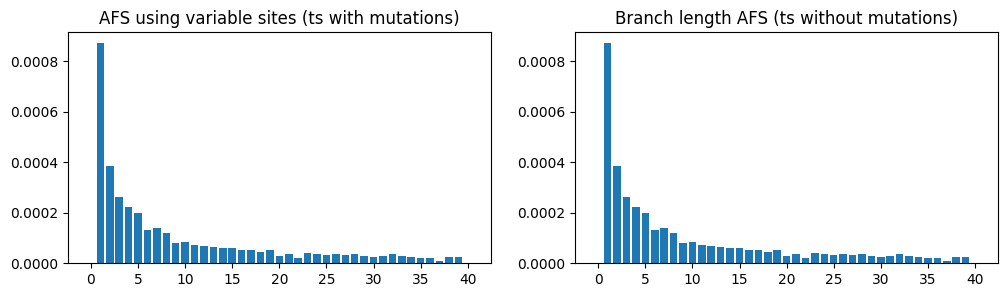

In [6]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3))

afs1 = ts_mutated.allele_frequency_spectrum(polarised=True, mode="site")
ax1.bar(np.arange(ts_mutated.num_samples+1), afs1)
ax1.set_title("AFS using variable sites (ts with mutations)")

afs2 = ts_no_mut.allele_frequency_spectrum(polarised=True, mode="branch")
ax2.bar(np.arange(ts_no_mut.num_samples+1), afs1)
ax2.set_title("Branch length AFS (ts without mutations)")

plt.show()

In this case, the plots are almost identical because there are thousands of
mutations over the entire sequence, so the mutational noise has been smoothed out
(the remaining unevenness in the AFS plots is due to stochasticity in genealogy, rather
than the mutations).

However, if we are doing a windowed analysis, and the windows over
the genome are small, each window will contain relatively few mutations, and statistics
based on the genetic variation generated by mutations will be be subject to greater
mutational noise than those based on branch lengths in the genealogy. Here's an
example using the basic {meth}`genetic diversity <tskit.TreeSequence.diversity>`
in 1Kb windows along our simulated genome:

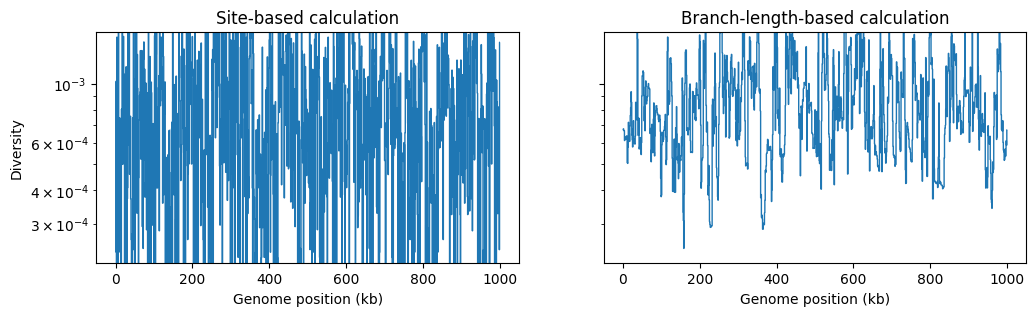

In [7]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3), sharey=True)
w = np.linspace(0, L, num=L//1_000)
ax1.stairs(ts_mutated.diversity(windows=w), w/1_000, baseline=None)
ax1.set_ylabel("Diversity")
ax1.set_xlabel("Genome position (kb)")
ax1.set_title("Site-based calculation")
ax1.set_yscale("log")
ax2.stairs(ts_no_mut.diversity(windows=w, mode="branch") * mu, w/1_000, baseline=None)
ax2.set_xlabel("Genome position (kb)")
ax2.set_title("Branch-length-based calculation")
ax2.set_yscale("log")
plt.show()

## Summary

In summary, if you are analysing tree sequences, especially those produced by simulation,
think carefully. Do you really need to analyse information about alleles and mutations?
If not, you may be able to omit sites and mutations from the tree sequence,
yet still retain the ability to calculate parameters of interest. This genealogical
approach can provide more accurate descriptors of the quantities of interest
than those explicitly based on genetic variation.